In [1]:
import numpy as np
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
import cmath

In [2]:
# Definitions:

def bin_averages(bins, array):
    """bins = contains number of lines to average in each bin, dump_bin
       array = contains TE, KE, PE array with each column representing frames"""
    start_idx = 0
    arr_avg = []
    for interval in bins:
        end_idx = start_idx + interval
        subset = array[start_idx:end_idx]
        avg = np.mean(subset, axis=0)
        arr_avg.append(avg)
        start_idx = end_idx
    return np.array(arr_avg)

In [3]:
# Input variables:
N_bins = 100                         # use 200, number of bins to be used

relaxid = "388586"
dump_file = "dump_trial.lmc"         # LAMMPS outfile 
dump_ref_ene = "baseline_energy_388586.lmc" # Contains information of baseline energy/atom

Lz = 4733.74             # Length of box in Z-direction in Angstrom, required to correct PBC
N_atoms = 681120         # Number of atoms
N_layeratom = 360        # Number of atoms in each Au(111) layer N_atoms/N_layer
offset_p = 38            # Lines to skip in data file

In [4]:
# Reading the baseline_energy dump file:
with open(dump_ref_ene, "r") as file:
    elines = file.readlines()
    eline = elines[11:]

    dump_ref = np.array([list(map(float, line.strip().split())) for line in eline])
    sorted_index = np.argsort(dump_ref[:, -4])   # Z_position    
    dump_ref = dump_ref[sorted_index]            # All the dump values sorted a/c to Z-position
#     print("Shape of position:", dump_pos.shape)
    Z_pos_ref = dump_ref[:, -4]
    
# Extracting energies, sorted a/c to Z-position, low Z to high Z
    TE_ref = dump_ref[:, -1]
    KE_ref = dump_ref[:, -2]
    PE_ref = dump_ref[:, -3]

In [5]:
# Reading the dump file:
with open(dump_file, "r") as file:
    lines = file.readlines()
    print(len(lines))

4086774


In [6]:
xlo = list(map(float, lines[5].strip().split()))[0]
xhi = list(map(float, lines[5].strip().split()))[1]
ylo = list(map(float, lines[6].strip().split()))[0]
yhi = list(map(float, lines[6].strip().split()))[1]
zlo = list(map(float, lines[7].strip().split()))[0]
zhi = list(map(float, lines[7].strip().split()))[1]

bin_width = (zhi-zlo)/N_bins         # in Angstrom
print("Number of bins:", N_bins, "Bin width:", bin_width, "A")

Number of bins: 100 Bin width: 47.33738584993999 A


In [7]:
Total_lines = len(lines)                    # Total no. of lines
Total_frames = Total_lines//(N_atoms + 9)    # Count all the frames

In [8]:
# Dump format: x = 4, y = 5, z=6, PE=7, KE=8, TE=9
offset_p = 9
Z_pos = np.zeros((N_atoms, Total_frames)) # 358560 X 14(frames)
TE = np.zeros((N_atoms, Total_frames))    # Total energy
KE = np.zeros((N_atoms, Total_frames))    # Kinetic energy
PE = np.zeros((N_atoms, Total_frames))    # Potential energy


for i in np.arange(Total_frames):
    # Read position data:
    a = int(N_atoms*i + offset_p*(i+1))
    b = int((N_atoms + offset_p)*(i+1))
    plines = lines[a:b]

    dump_pos = np.array([list(map(float, line.strip().split())) for line in plines])
    sorted_index = np.argsort(dump_pos[:, -4])       
    dump_pos = dump_pos[sorted_index]            # All the dump values sorted a/c to Z-position
#     print("Shape of position:", dump_pos.shape)
    Z_pos[:, i] = dump_pos[:, -4]
    
# Extracting energies, sorted a/c to Z-position, low Z to high Z
    TE[:, i] = dump_pos[:, -1]
    KE[:, i] = dump_pos[:, -2]
    PE[:, i] = dump_pos[:, -3]
  

In [9]:
bins = np.array([(zlo+i*bin_width) for i in range(N_bins)]);
# print("First 5 bins:\n",[(bins[i], bins[i+1]) for i in range(len(bins)-1)][0:5])

binned_data = {}                       # Dictionary
for z in Z_pos[:, 0]:
    if z < zlo or z >= zhi:
        continue
    bin_num = (z - zlo) // bin_width;  # Calculates the bin numbers
    if bin_num in binned_data:
        binned_data[bin_num].append(z) # use the bin number and collect the z values
    else:
        binned_data[bin_num] = [z]   
        
dump_bin = np.array([len(binned_data[i]) for i 
                     in range(len(binned_data))]) # calculates no. of lines to average

In [10]:
# Averaging the reference energies:
KE_avg_ref = bin_averages(dump_bin, KE_ref)
PE_avg_ref = bin_averages(dump_bin, PE_ref)
TE_avg_ref = bin_averages(dump_bin, TE_ref)

# Now lets average the energies TE, KE, PE over the bins and subtract the baseline energy:
KE_avg = bin_averages(dump_bin, KE) - KE_avg_ref[:, None] @ np.ones((1, Total_frames))
PE_avg = bin_averages(dump_bin, PE) - PE_avg_ref[:, None] @ np.ones((1, Total_frames))
TE_avg = bin_averages(dump_bin, TE) - TE_avg_ref[:, None] @ np.ones((1, Total_frames))
Z_avg = bin_averages(dump_bin, Z_pos)     # Bin centers

# Subtracting energy of first frame:
# TE_avg = TE_avg - TE_avg[:, 0][:, None] @ np.ones((1, Total_frames))

# Saving the raw_energy_values:
np.savetxt("KE_bins.dat", np.hstack((Z_avg[:,0][:, None], KE_avg)))
np.savetxt("PE_bins.dat", np.hstack((Z_avg[:,0][:, None], PE_avg)))
np.savetxt("TE_bins.dat", np.hstack((Z_avg[:,0][:, None], TE_avg)))

In [11]:
# Taking the absolute value and dividing by kB:
kB = 8.617333262e-5         #eVK-1
KE_avg = np.abs(KE_avg)
PE_avg = np.abs(PE_avg)
TE_avg = np.abs(TE_avg)

In [12]:
ene_avg_freq = 3        # Every 2 frames, if frames are dumped every ps then every 2 ps
x = KE_avg.shape[0]
y = KE_avg.shape[1]
KE_avg_fram = np.mean(KE_avg.reshape((x, y//ene_avg_freq, ene_avg_freq)), axis=-1)
PE_avg_fram = np.mean(PE_avg.reshape((x, y//ene_avg_freq, ene_avg_freq)), axis=-1)
TE_avg_fram = np.mean(TE_avg.reshape((x, y//ene_avg_freq, ene_avg_freq)), axis=-1)

In [13]:
# Saving the energies after averaging the frames
np.savetxt("KE_bins_frames.dat", np.hstack((Z_avg[:,0][:, None], KE_avg_fram)))
np.savetxt("PE_bins_frames.dat", np.hstack((Z_avg[:,0][:, None], PE_avg_fram)))
np.savetxt("TE_bins_frames.dat", np.hstack((Z_avg[:,0][:, None], TE_avg_fram)))

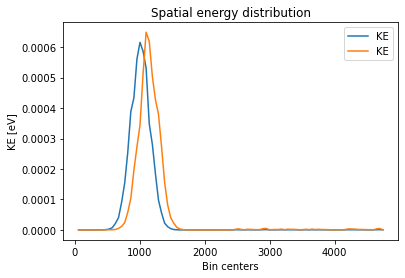

In [17]:
plt.plot(Z_avg[:, 0], KE_avg_fram, '-', label='KE')
plt.xlabel('Bin centers')
plt.ylabel('KE [eV]')
plt.title('Spatial energy distribution')
plt.legend()
plt.show()